In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

# Convolutional Neural Networks

In [2]:
def zero_pad(X, pad):
    """
    Pad with zeros all images of the dataset X. The padding is applied to the height and width of an image.
    
    Argument:
    X -- python numpy array of shape (m, n_H, n_W, n_C) representing a batch of m images
    pad -- integer, amount of padding around each image on vertical and horizontal dimensions
    
    Returns:
    X_pad -- padded image of shape (m, n_H + 2*pad, n_W + 2*pad, n_C)
    """
    X_pad = np.pad(X, ((0, 0), (pad, pad), (pad, pad), (0, 0)), 'constant', constant_values=0)
    
    return X_pad

In [3]:
def conv_single_step(a_slice_prev, W, b):
    """
    Apply one filter defined by parameters W on a single slice (a_slice_prev) of the output activation 
    of the previous layer.
    
    Arguments:
    a_slice_prev -- slice of input data of shape (f, f, n_C_prev)
    W -- Weight parameters contained in a window - matrix of shape (f, f, n_C_prev)
    b -- Bias parameters contained in a window - matrix of shape (1, 1, 1)
    
    Returns:
    Z -- a scalar value, result of convolving the sliding window (W, b) on a slice x of the input data
    """
    s = np.multiply(a_slice_prev, W) + b
    Z = np.sum(s)
    
    return Z

In [5]:
def conv_forward(A_prev, W, b, hparemeters):
    """
    Implements the forward propagation for a convolution function
    
    Arguments:
    A_prev -- output activations of the previous layer, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    W -- Weights, numpy array of shape (f, f, n_C_prev, n_C)
    b -- Biases, numpy array of shape (1, 1, 1, n_C)
    hparameters -- python dictionary containing "stride" and "pad"
        
    Returns:
    Z -- conv output, numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache of values needed for the conv_backward() function
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    (f, f, n_C_prev, n_C) = W.shape
    stride = hparemeters['stride']
    pad = hparemeters['pad']
    
    n_H = int((n_H_prev - f + 2*pad) / stride) + 1
    n_W = int((n_W_prev - f + 2*pad) / stride) + 1
    
    Z = np.zeros((m, n_H, n_W, n_C))
    
    A_prev_pad = zero_pad(A_prev, pad)
    
    for i in range(m):
        a_prev_pad = A_prev_pad[i]
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    ver_end = ver_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_slice_prev = a_prev_pad[vert_start:ver_end, horiz_start:horiz_end, :]
                    Z[i, h, w, c] = conv_single_step(a_slice_prev, W[...,c], b[...,c])
                    
    cache = (A_prev, W, b, hparemeters)
    return Z, cache

# Pooling layer
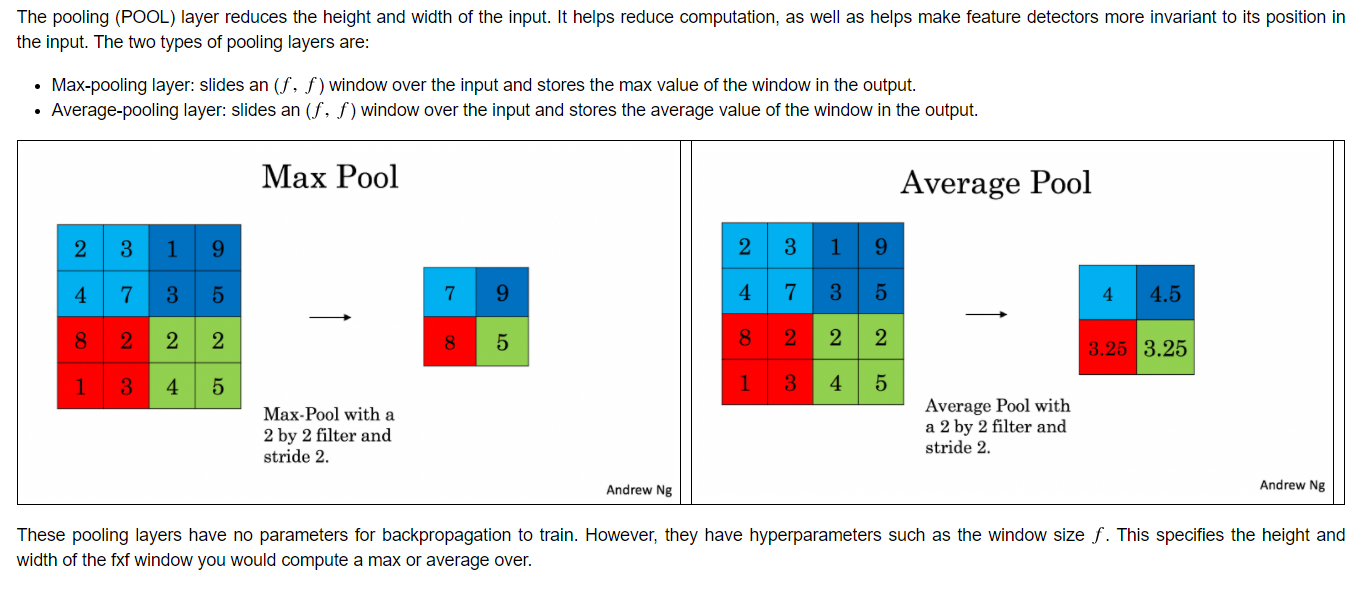

In [6]:
def pool_forward(A_prev, hparameters, mode = 'max'):
    """
    Implements the forward pass of the pooling layer
    
    Arguments:
    A_prev -- Input data, numpy array of shape (m, n_H_prev, n_W_prev, n_C_prev)
    hparameters -- python dictionary containing "f" and "stride"
    mode -- the pooling mode you would like to use, defined as a string ("max" or "average")
    
    Returns:
    A -- output of the pool layer, a numpy array of shape (m, n_H, n_W, n_C)
    cache -- cache used in the backward pass of the pooling layer, contains the input and hparameters 
    """
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape
    f = hparameters['f']
    stride = hparameters['stride']
    
    n_H = int((n_H_prev - f) / stride) + 1
    n_W = int((n_W_prev - f) / stride) + 1
    n_C = n_C_prev
    
    A = np.zeros((m, n_H, n_W, n_C))
    
    for i in range(m):
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    vert_start = h * stride
                    ver_end = ver_start + f
                    horiz_start = w * stride
                    horiz_end = horiz_start + f
                    a_prev_slice = A_prev[i, vert_start:vert_end, horiz_start:horiz_end, c]
                    
                    if mod == 'max':
                        A[i, h, w, c] = np.max(a_prev_slice)
                    elif mod == 'average':
                        A[i, h, w, c] = np.mean(a_prev_slice)
    
    cache = (A_prev, hparameters)
    
    return A, cache

# Backpropagation

## Convolutional layer backward
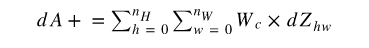